In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit
import time
from tqdm import tqdm
import json
import scg
import importlib
import lfrog
from contextlib import redirect_stdout
from autorank import autorank, plot_stats
import scikit_posthocs as sp
import io
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import ShuffleSplit

In [2]:
seed = 40
torch.manual_seed(seed)
np.random.seed(seed)

### Loading and downsampling data

In [8]:
data = pd.read_csv('../data/scurve_data.csv')

y = data['y']
X = data.drop(columns='y')

sss = ShuffleSplit(n_splits=1, train_size=10000, random_state=42)
for train_idx, _ in sss.split(X, y):
    X_s = X.iloc[train_idx]
    y_s = y.iloc[train_idx]

### K-fold setup

In [9]:
def generate_folds(X, y, n_folds = 10):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    folds = []
    splits = kf.split(X, y)
    for train_index, val_index in splits:
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        folds.append({'Xt': X_train, 'Xv': X_val, 'yt': y_train, 'yv': y_val})
    return folds

In [10]:
folds = generate_folds(X_s, y_s, 10)

### Auxiliary functions

In [11]:
def extend_with_last(arr, target_length):
    return arr + [arr[-1]] * (target_length - len(arr)) 

class FeedforwardNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.act = nn.ReLU()  
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

def plot_results(results_in, show=True, title='Loss Curve for Classification Problem', fold_i='', ytop=0.8): 
    plt.plot(results_in['train_losses_by_epochs'], label=f'Train Loss: {fold_i}')
    plt.plot(results_in['val_losses'], label=f'Validation Loss: {fold_i}')
    plt.ylim(0, ytop) 
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    if show == True:
        plt.legend()
        plt.show()

class CustomJSONEncoder(json.JSONEncoder):
    def default(self, obj):
        try:
            return super().default(obj)
        except TypeError:
            pass
        if hasattr(obj, '__dict__'):
            return obj.__dict__
        elif hasattr(obj, '__str__'):
            return str(obj)
        else:
            return f"<non-serializable: {type(obj).__name__}>"

def save_json(data, path, indent=4):
    with open(path, "w") as f:
        json.dump(data, f, indent=indent, cls=CustomJSONEncoder)

def extract_losses_and_accuracy(results):
    out = {}
    for dim_key in list(results.keys()):
        out_folds = {}
        for fold_key in list(results[dim_key].keys()):
            data = results[dim_key][fold_key]
            temp = {}
            temp['train_losses_by_epochs'] = data['train_losses_by_epochs']
            temp['val_losses'] = data['val_losses']
            temp['train_r2s'] = data['train_r2s']
            temp['val_r2s'] = data['val_r2s']
            temp['global_duration'] = data['global_duration']
            temp['epoch_durations'] = data['epoch_durations']
            temp['total_epochs'] = data['total_epochs']
            out_folds[fold_key] = temp
        out[dim_key] = out_folds
    return out

def plot_per_dim(dim_results, title="Loss Curve for Classification Problem 1: Hidden dimension = 1"):
    for key in list(dim_results.keys()):
        plot_results(dim_results[key], show=False, fold_i=key, title=title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.3))
    plt.tight_layout()    
    plt.show()

def find_time_to_convergence(results_folded, threshold=0.005, max_time=1e6):
    out = {}
    val_wall = []
    val_epoch = []
    train_wall = []
    train_epoch = []
    for key in list(results_folded.keys()):
        val_wall.append(convergence_time(results_folded[key], threshold=threshold, max_time=max_time, key='val_losses', wall_time=True))
        val_epoch.append(convergence_time(results_folded[key], threshold=threshold, max_time=max_time, key='val_losses', wall_time=False))
        train_wall.append(convergence_time(results_folded[key], threshold=threshold, max_time=max_time, key='train_losses_by_epochs', wall_time=True))
        train_epoch.append(convergence_time(results_folded[key], threshold=threshold, max_time=max_time, key='train_losses_by_epochs', wall_time=False))
    out['val_wall'] = val_wall
    out['val_epoch'] = val_epoch
    out['train_wall'] = train_wall
    out['train_epoch'] = train_epoch
    return out

def convergence_time(result_run, threshold=0.005, max_time=1e6, key='val_losses', wall_time=True):
    list_in = np.array(result_run[key])
    n = len(list_in)
    for i in range(n):
        if all(v < threshold for v in list_in[i:]):
            if wall_time == True:
                out = np.array(result_run['epoch_durations'])
                return float(np.sum(out[:i + 1]))
            else: 
                return float(i + 1)
    return max_time

def estimate_avg_time_to_convergence(results_folded, threshold=0.005, max_time=1e6):
    res = find_time_to_convergence(results_folded, threshold, max_time)
    out = {}

    out['val_wall_avg'] = float(np.mean(res['val_wall']))
    out['val_wall_std'] = float(np.std(res['val_wall']))

    out['val_epoch_avg'] = float(np.mean(res['val_epoch']))
    out['val_epoch_std'] = float(np.std(res['val_epoch']))

    out['train_wall_avg'] = float(np.mean(res['train_wall']))
    out['train_wall_std'] = float(np.std(res['train_wall']))

    out['train_epoch_avg'] = float(np.mean(res['train_epoch']))
    out['train_epoch_std'] = float(np.std(res['train_epoch']))
    return out

def find_best_config(results, test_key='val_wall', threshold=0.05):
    best_key = None
    best_result = np.inf
    for key in list(results.keys()):
        temp = estimate_avg_time_to_convergence(results[key], threshold=threshold)[f"{test_key}_avg"]
        if temp < best_result:
            best_result = temp
            best_key = key
    return {'config': best_key, 'metric': best_result}

def sort_configs(results, test_key='val_wall', threshold=0.05):
    sorted_keys = sorted(
        results.keys(),
        key=lambda k: estimate_avg_time_to_convergence(results[k], threshold=threshold)[f"{test_key}_avg"],
        reverse=False
    )
    return sorted_keys

## SGD

### Model Training function

In [14]:
def train_sgd_model(fold, hidden_dim=2, input_dim=3, output_dim=1, 
                         batch_size=1, learning_rate=0.01, max_epochs=10, 
                         to_print=True, patience=10): 
    X_val = torch.tensor(fold['Xv'].values, dtype=torch.float32)
    y_val = torch.tensor(fold['yv'].values, dtype=torch.float32)
    X_train = torch.tensor(fold['Xt'].values, dtype=torch.float32)
    y_train = torch.tensor(fold['yt'].values, dtype=torch.float32)

    train_dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = FeedforwardNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_r2s, val_r2s = [], []
    times = []
    best_val_loss = float('inf')
    epochs_since_improve = 0
    global_start = time.time()
    total_epochs_ran = 0

    def r2_score(y_true, y_pred):
        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

    for epoch in range(max_epochs):
        local_start = time.time()
        model.train()
        train_loss = 0.0
        preds_all = []
        y_all = []
        for batch_X, batch_y in loader: 
            optimizer.zero_grad()
            outputs = model(batch_X)
            outputs = outputs.view(-1)       
            batch_y = batch_y.view(-1)       
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_y.size(0)
            preds_all.append(outputs.detach())
            y_all.append(batch_y)
        
        preds_all = torch.cat(preds_all)
        y_all = torch.cat(y_all)
        avg_train_loss = train_loss / len(y_train)
        train_r2 = r2_score(y_all, preds_all).item()
        train_losses.append(avg_train_loss)
        train_r2s.append(train_r2)
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val).view(-1)
            val_loss = criterion(val_outputs, y_val.view(-1)).item()
            val_r2 = r2_score(y_val.view(-1), val_outputs).item()
            val_losses.append(val_loss)
            val_r2s.append(val_r2)

        if val_loss < best_val_loss - 1e-6:  
            best_val_loss = val_loss
            epochs_since_improve = 0
        else:
            epochs_since_improve += 1

        local_stop = time.time()
        local_duration = local_stop - local_start
        times.append(local_duration)
        total_epochs_ran += 1

        if to_print:
            print(f"Epoch {epoch+1}/{max_epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Train R²: {train_r2:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Val R²: {val_r2:.4f} | "
                  f"Duration: {local_duration:.4f}")
            
        if epochs_since_improve >= patience:
            if to_print:
                print(f"Early stopping at epoch {epoch+1}")
            break
            
    global_end = time.time()
    global_duration = global_end - global_start

    results = {
        "model": model,
        "train_losses_by_epochs": train_losses,
        "val_losses": val_losses,
        "train_r2s": train_r2s,
        "val_r2s": val_r2s,
        "global_duration": global_duration, 
        "epoch_durations": times,
        "total_epochs": total_epochs_ran
    }
    return results


### Evals of dimension and learning rate

Epoch 1/10 | Train Loss: 0.0961 | Train R²: 0.9045 | Val Loss: 0.0657 | Val R²: 0.9341 | Duration: 4.2902
Epoch 2/10 | Train Loss: 0.0664 | Train R²: 0.9340 | Val Loss: 0.0725 | Val R²: 0.9273 | Duration: 4.4487
Epoch 3/10 | Train Loss: 0.0658 | Train R²: 0.9346 | Val Loss: 0.0646 | Val R²: 0.9352 | Duration: 4.2076
Epoch 4/10 | Train Loss: 0.0653 | Train R²: 0.9351 | Val Loss: 0.0623 | Val R²: 0.9375 | Duration: 4.2285
Epoch 5/10 | Train Loss: 0.0655 | Train R²: 0.9349 | Val Loss: 0.0646 | Val R²: 0.9352 | Duration: 4.1143
Epoch 6/10 | Train Loss: 0.0657 | Train R²: 0.9348 | Val Loss: 0.0619 | Val R²: 0.9379 | Duration: 4.1025
Epoch 7/10 | Train Loss: 0.0653 | Train R²: 0.9352 | Val Loss: 0.0627 | Val R²: 0.9371 | Duration: 4.1512
Epoch 8/10 | Train Loss: 0.0651 | Train R²: 0.9353 | Val Loss: 0.0630 | Val R²: 0.9368 | Duration: 4.0469
Epoch 9/10 | Train Loss: 0.0653 | Train R²: 0.9351 | Val Loss: 0.0820 | Val R²: 0.9177 | Duration: 4.0482
Epoch 10/10 | Train Loss: 0.0653 | Train R²: 0

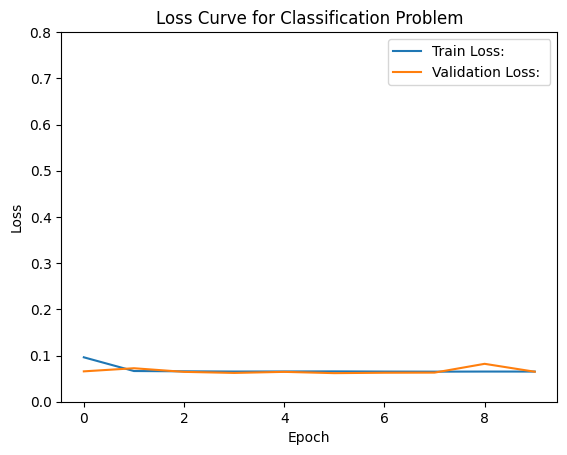

In [18]:
res = train_sgd_model(folds[0], hidden_dim=2, max_epochs=10)
plot_results(res)

In [20]:
def find_optimal_hidden_layers(folds, dim_list = [1, 2, 3], max_epochs=20, learning_rate=0.01):
    results = {}
    for n in dim_list:
        results_per_size = {}
        for i in tqdm(range(len(folds))):
            results_per_size[f'fold_{i}'] = train_sgd_model(folds[i], hidden_dim=n, max_epochs=max_epochs, learning_rate=learning_rate, to_print=False)
        results[f'dim_{n}'] = results_per_size
    return results 

In [21]:
dim_results = find_optimal_hidden_layers(folds, dim_list=[2, 3, 4, 5])
save_json(extract_losses_and_accuracy(dim_results), '../results/regression_2/hidden_dim_test.json')

100%|██████████| 10/10 [12:46<00:00, 76.64s/it]


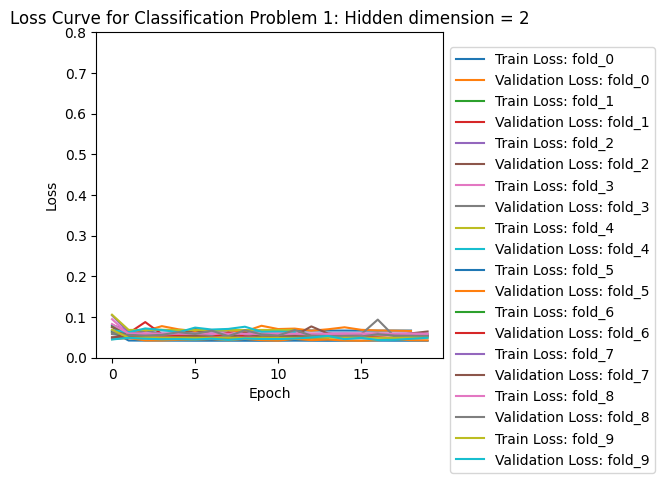

In [22]:
plot_per_dim(dim_results['dim_2'], title="Loss Curve for Classification Problem 1: Hidden dimension = 2")

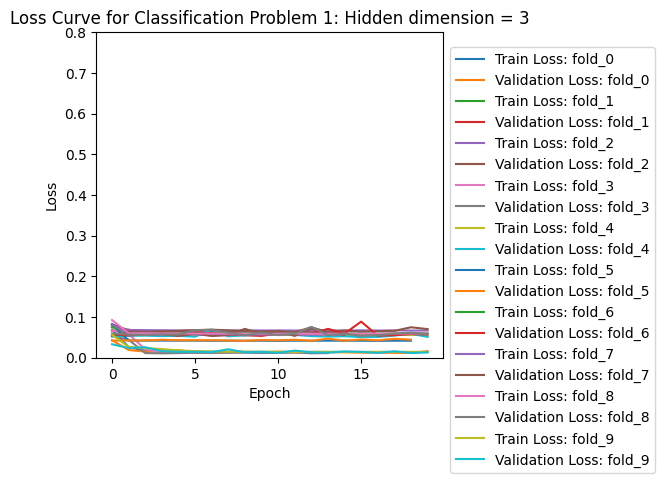

In [23]:
plot_per_dim(dim_results['dim_3'], title="Loss Curve for Classification Problem 1: Hidden dimension = 3")

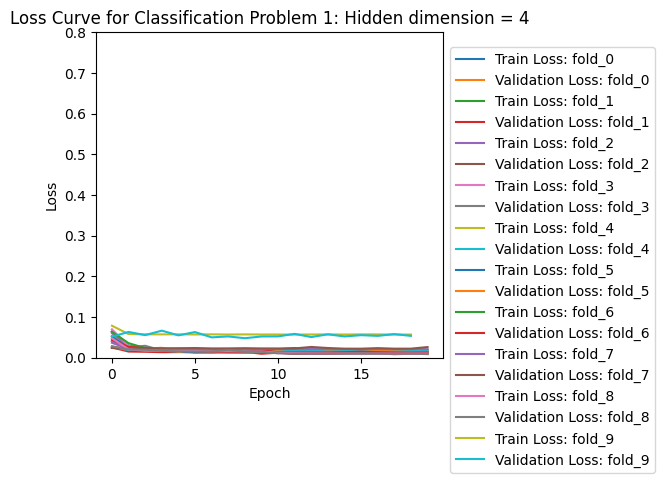

In [24]:
plot_per_dim(dim_results['dim_4'], title="Loss Curve for Classification Problem 1: Hidden dimension = 4")

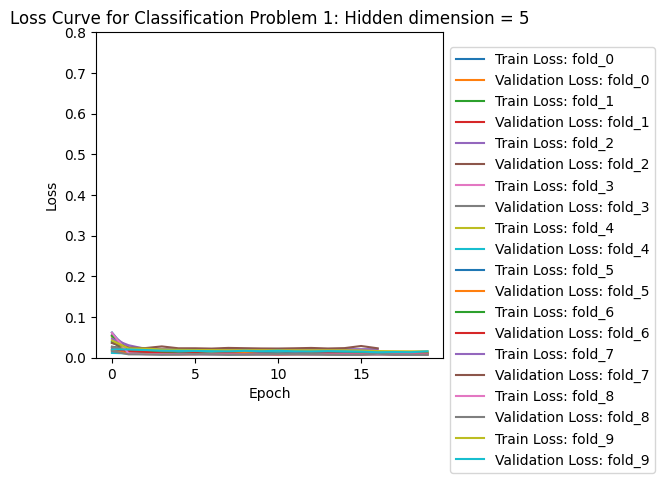

In [25]:
plot_per_dim(dim_results['dim_5'], title="Loss Curve for Classification Problem 1: Hidden dimension = 5")

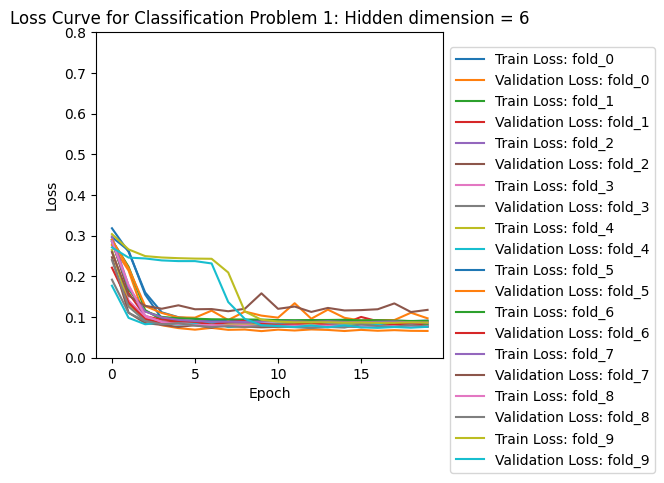

In [16]:
plot_per_dim(dim_results['dim_6'], title="Loss Curve for Classification Problem 1: Hidden dimension = 6")

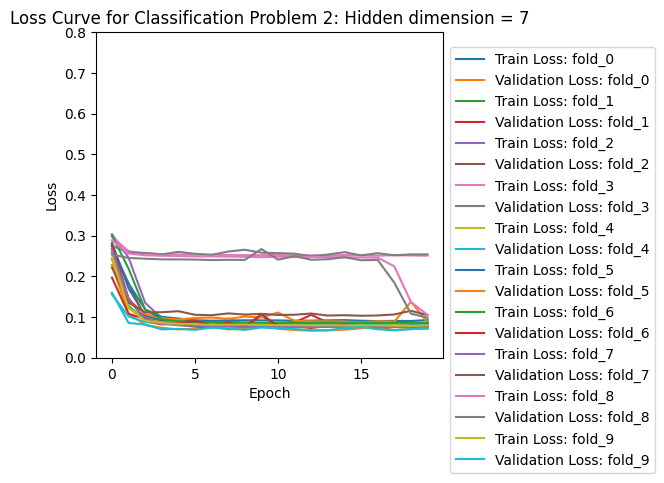

In [17]:
plot_per_dim(dim_results['dim_7'], title="Loss Curve for Classification Problem 2: Hidden dimension = 7")

In [27]:
def find_optimal_learning_rate(folds, lr_list = [1, 2, 3], max_epochs=20):
    results = {}
    for l in lr_list:
        results_per_size = {}
        for i in tqdm(range(len(folds))):
            results_per_size[f'fold_{i}'] = train_sgd_model(folds[i], hidden_dim=5, max_epochs=max_epochs, learning_rate=l, to_print=False, patience=10)
        results[f'lr_{l}'] = results_per_size
    return results 

In [28]:
lr_candidates = [5e-3, 1e-2, 5e-2, 1e-1]

dim_results_lr = find_optimal_learning_rate(folds, lr_list=lr_candidates)
save_json(extract_losses_and_accuracy(dim_results_lr), '../results/regression_2/lr_test.json')

100%|██████████| 10/10 [11:56<00:00, 71.66s/it]


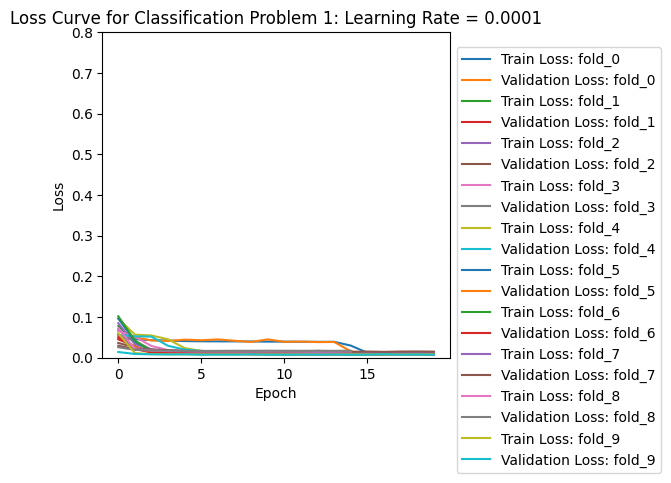

In [30]:
plot_per_dim(dim_results_lr['lr_0.005'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.0001")

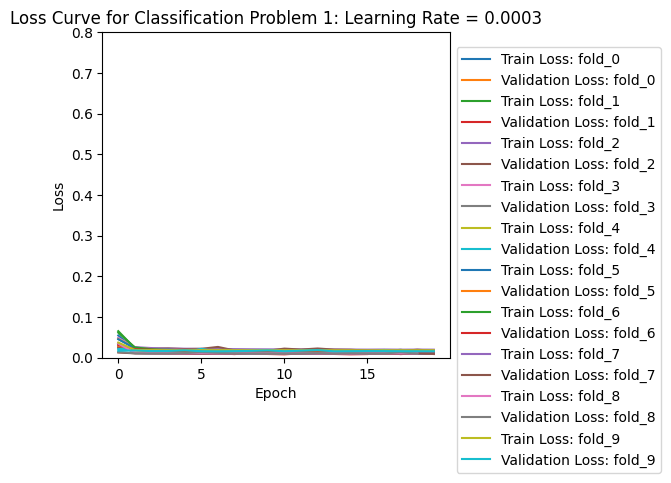

In [31]:
plot_per_dim(dim_results_lr['lr_0.01'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.0003")

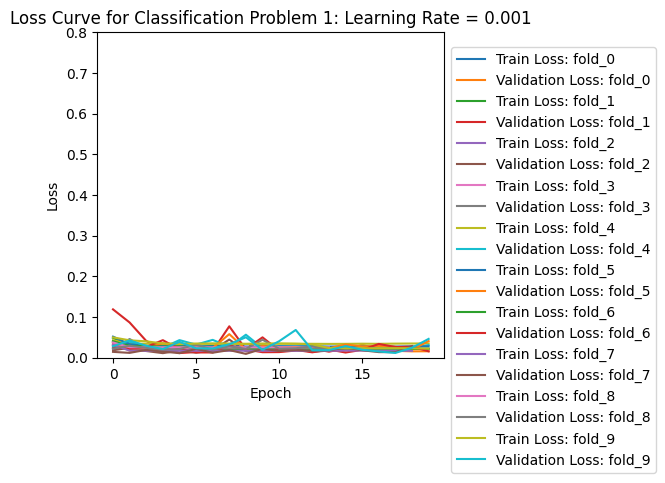

In [33]:
plot_per_dim(dim_results_lr['lr_0.05'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.001")

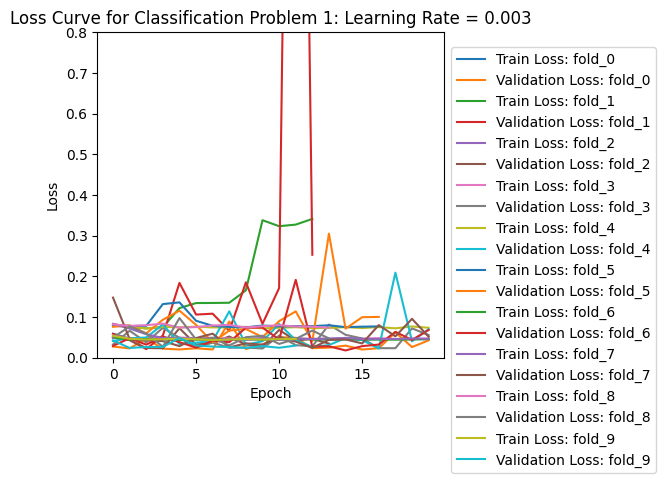

In [34]:
plot_per_dim(dim_results_lr['lr_0.1'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.003")

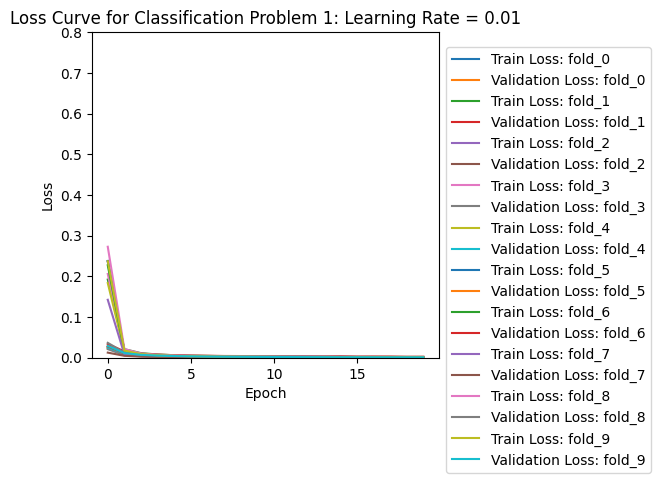

In [186]:
plot_per_dim(dim_results_lr['lr_0.01'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.01")

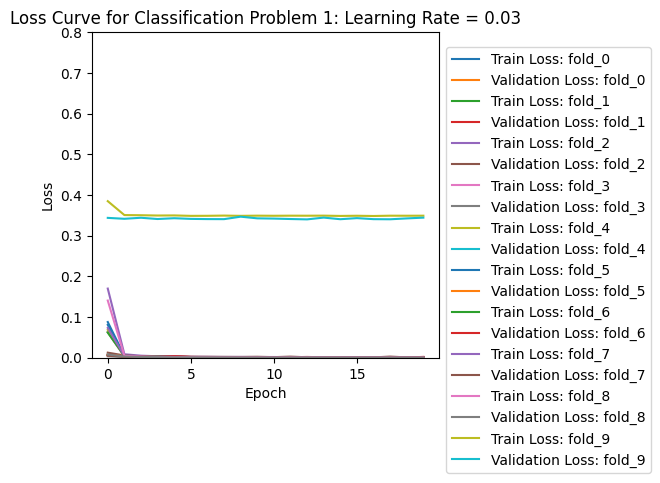

In [187]:
plot_per_dim(dim_results_lr['lr_0.03'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.03")

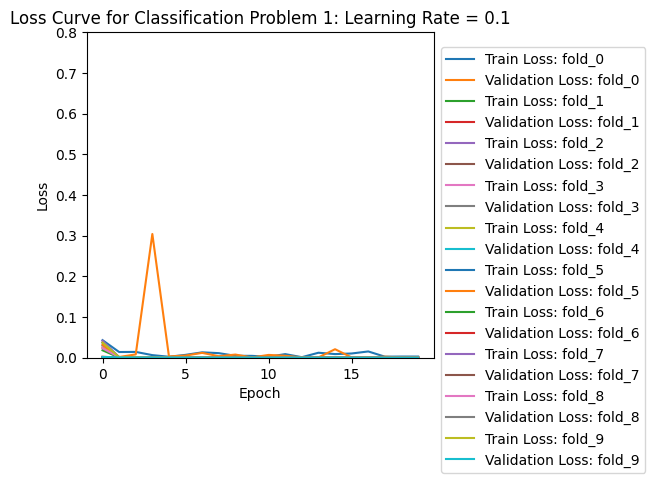

In [188]:
plot_per_dim(dim_results_lr['lr_0.1'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.1")

## SCG

In [38]:
importlib.reload(scg)
from scg import SCG

def train_scg_model(
    fold,
    hidden_dim=5,
    input_dim=3,
    output_dim=1,
    max_epochs=10,
    sigma=1e-4,
    lambd=1e-6,
    to_print=True,
    patience=10
):
    X_val = torch.tensor(fold['Xv'].values, dtype=torch.float32)
    y_val = torch.tensor(fold['yv'].values, dtype=torch.float32).view(-1)
    X_train = torch.tensor(fold['Xt'].values, dtype=torch.float32)
    y_train = torch.tensor(fold['yt'].values, dtype=torch.float32).view(-1)

    model = FeedforwardNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    criterion = nn.MSELoss() 
    optimizer = SCG(model.parameters(), sigma=sigma, lambd=lambd)

    train_losses = []
    val_losses = []
    train_r2s = []
    val_r2s = []
    times = []
    best_val_loss = float('inf')
    epochs_since_improve = 0
    global_start = time.time()
    total_epochs_ran = 0

    def r2_score(y_true, y_pred):
        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

    for epoch in range(max_epochs):
        local_start = time.time()
        model.train()

        def closure():
            optimizer.zero_grad()
            outputs = model(X_train).view(-1)  
            loss = criterion(outputs, y_train)
            return loss

        loss = optimizer.step(closure)
        train_loss = loss.item()

        with torch.no_grad():
            outputs = model(X_train).view(-1)
            train_r2 = r2_score(y_train, outputs).item()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val).view(-1)
            val_loss = criterion(val_outputs, y_val).item()
            val_r2 = r2_score(y_val, val_outputs).item()

        train_losses.append(train_loss)
        train_r2s.append(train_r2)
        val_losses.append(val_loss)
        val_r2s.append(val_r2)

        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            epochs_since_improve = 0
        else:
            epochs_since_improve += 1

        local_stop = time.time()
        local_duration = local_stop - local_start
        times.append(local_duration)
        total_epochs_ran += 1

        if to_print:
            print(f"Epoch {epoch+1}/{max_epochs} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Train R²: {train_r2:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Val R²: {val_r2:.4f} | "
                  f"Duration: {local_duration:.4f}")

        if epochs_since_improve >= patience:
            if to_print:
                print(f"Early stopping at epoch {epoch+1}")
            break

    global_end = time.time()
    global_duration = global_end - global_start

    results = {
        "model": model,
        "train_losses_by_epochs": train_losses,
        "val_losses": val_losses,
        "train_r2s": train_r2s,
        "val_r2s": val_r2s,
        "global_duration": global_duration,
        "epoch_durations": times,
        "total_epochs": total_epochs_ran
    }
    return results



In [39]:
def find_optimal_hidden_layer_scg(folds, dim_list = [1, 2, 3], max_epochs=2000):
    results = {}
    for n in dim_list:
        results_per_size = {}
        for i in tqdm(range(len(folds))):
            results_per_size[f'fold_{i}'] = train_scg_model(folds[i], hidden_dim=n, max_epochs=max_epochs, lambd=1e-1, sigma=1e-1, to_print=False, patience=1000)
        results[f'dim_{n}'] = results_per_size
    return results 

In [40]:
dim_results_scg = find_optimal_hidden_layer_scg(folds, dim_list=[5], max_epochs=1000)
save_json(extract_losses_and_accuracy(dim_results_scg), '../results/regression_2/hidden_dim_test_scg.json')

100%|██████████| 10/10 [04:22<00:00, 26.29s/it]


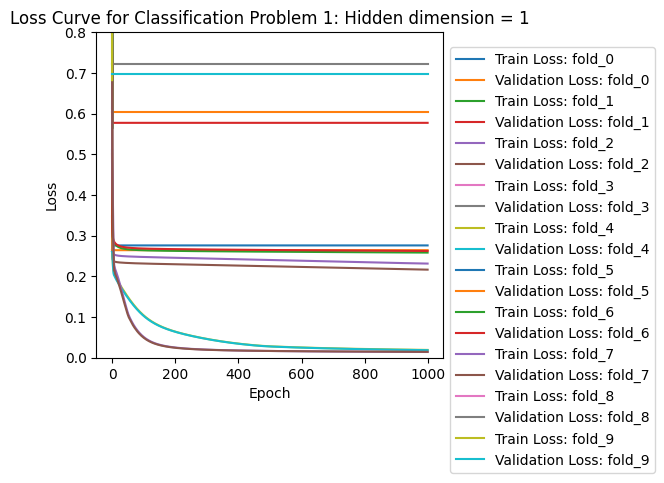

In [79]:
plot_per_dim(dim_results_scg['dim_5'])

Epoch 1/1000 | Train Loss: 0.7998 | Train R²: 0.2072 | Val Loss: 0.7947 | Val R²: 0.2053 | Duration: 0.0056
Epoch 2/1000 | Train Loss: 0.2911 | Train R²: 0.7115 | Val Loss: 0.2887 | Val R²: 0.7113 | Duration: 0.0040
Epoch 3/1000 | Train Loss: 0.2745 | Train R²: 0.7278 | Val Loss: 0.2758 | Val R²: 0.7242 | Duration: 0.0041
Epoch 4/1000 | Train Loss: 0.2670 | Train R²: 0.7353 | Val Loss: 0.2717 | Val R²: 0.7283 | Duration: 0.0042
Epoch 5/1000 | Train Loss: 0.2570 | Train R²: 0.7452 | Val Loss: 0.2615 | Val R²: 0.7385 | Duration: 0.0040
Epoch 6/1000 | Train Loss: 0.2495 | Train R²: 0.7527 | Val Loss: 0.2517 | Val R²: 0.7483 | Duration: 0.0038
Epoch 7/1000 | Train Loss: 0.2452 | Train R²: 0.7570 | Val Loss: 0.2476 | Val R²: 0.7524 | Duration: 0.0045
Epoch 8/1000 | Train Loss: 0.2414 | Train R²: 0.7607 | Val Loss: 0.2435 | Val R²: 0.7565 | Duration: 0.0045
Epoch 9/1000 | Train Loss: 0.2384 | Train R²: 0.7637 | Val Loss: 0.2409 | Val R²: 0.7591 | Duration: 0.0150
Epoch 10/1000 | Train Loss: 

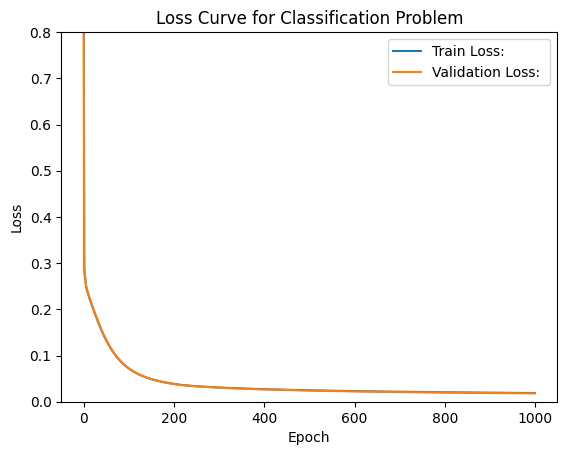

In [26]:
res = train_scg_model(folds[0], hidden_dim=8, max_epochs=1000, patience=300)
plot_results(res)

In [41]:
def optimize_hyper_params_scg(folds, sig_list, lam_list, max_epochs=1000):
    results = {}
    for s in sig_list:
        for l in lam_list:
            results_per_config = {}
            for i in tqdm(range(len(folds))):
                results_per_config[f'fold_{i}'] = train_scg_model(folds[i], max_epochs=max_epochs, sigma=s, hidden_dim=5, lambd=l, to_print=False, patience=1000)
            results[f'sigma_{s}_lambda_{l}'] = results_per_config
    return results 

In [42]:
sigmas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
lambdas = [1e-6, 1e-5, 1e-4]

scg_param_results = optimize_hyper_params_scg(folds, sigmas, lambdas)
save_json(extract_losses_and_accuracy(scg_param_results), '../results/regression_2/scg_hyperparam_test.json')

100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


In [270]:
sort_configs(scg_param_results, threshold=0.05)

['sigma_0.0001_lambda_0.0001',
 'sigma_1e-05_lambda_1e-05',
 'sigma_0.0003_lambda_0.0001',
 'sigma_0.0001_lambda_1e-06',
 'sigma_1e-06_lambda_1e-06',
 'sigma_3e-06_lambda_1e-06',
 'sigma_3e-05_lambda_1e-05',
 'sigma_0.0003_lambda_1e-05',
 'sigma_3e-06_lambda_1e-05',
 'sigma_0.0003_lambda_1e-06',
 'sigma_3e-06_lambda_0.0001',
 'sigma_1e-05_lambda_0.0001',
 'sigma_1e-05_lambda_1e-06',
 'sigma_1e-06_lambda_1e-05',
 'sigma_3e-05_lambda_0.0001',
 'sigma_1e-06_lambda_0.0001',
 'sigma_3e-05_lambda_1e-06',
 'sigma_0.0001_lambda_1e-05']

In [271]:
estimate_avg_time_to_convergence(scg_param_results['sigma_0.0001_lambda_0.0001'], threshold=0.1)

{'val_wall_avg': 0.35477285385131835,
 'val_wall_std': 0.1454466158440327,
 'val_epoch_avg': 53.2,
 'val_epoch_std': 22.457960726655482,
 'train_wall_avg': 0.35270659923553466,
 'train_wall_std': 0.14236678233829914,
 'train_epoch_avg': 52.9,
 'train_epoch_std': 21.920082116634507}

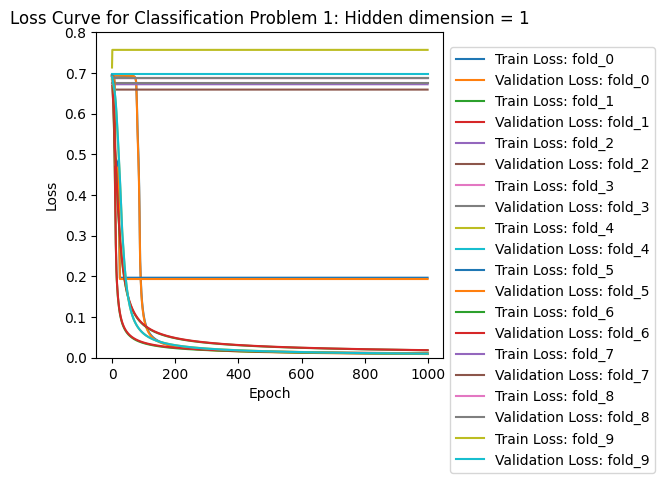

In [273]:
plot_per_dim(scg_param_results['sigma_0.0001_lambda_1e-05'])

## LFrog

In [49]:
importlib.reload(lfrog)
from lfrog import LeapfrogOptimizer

def train_leapfrog_model(
    fold,
    hidden_dim=5,
    input_dim=3,
    output_dim=1,
    max_epochs=10,
    time_step=0.5,
    delta_max=1.0,
    tol_grad=1e-5,
    j_threshold=2,
    to_print=True,
    patience=10
):
    # Prepare data
    X_val = torch.tensor(fold['Xv'].values, dtype=torch.float32)
    y_val = torch.tensor(fold['yv'].values, dtype=torch.float32).view(-1)
    X_train = torch.tensor(fold['Xt'].values, dtype=torch.float32)
    y_train = torch.tensor(fold['yt'].values, dtype=torch.float32).view(-1)

    model = FeedforwardNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    criterion = nn.MSELoss()

    optimizer = LeapfrogOptimizer(
        model.parameters(),
        time_step=time_step,
        delta_max=delta_max,
        tol_grad=tol_grad,
        j_threshold=j_threshold
    )

    train_losses = []
    val_losses = []
    train_r2s = []
    val_r2s = []
    times = []
    best_val_loss = float('inf')
    epochs_since_improve = 0
    global_start = time.time()
    total_epochs_ran = 0

    def r2_score(y_true, y_pred):
        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

    for epoch in range(max_epochs):
        local_start = time.time()
        model.train()

        # Closure for Leapfrog: must compute full-batch loss + backward
        def closure():
            optimizer.zero_grad()
            outputs = model(X_train).view(-1)
            loss = criterion(outputs, y_train)
            loss.backward()
            return loss

        # Step the optimizer
        loss = optimizer.step(closure)
        train_loss = loss.item()

        with torch.no_grad():
            outputs = model(X_train).view(-1)
            train_r2 = r2_score(y_train, outputs).item()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val).view(-1)
            val_loss = criterion(val_outputs, y_val).item()
            val_r2 = r2_score(y_val, val_outputs).item()

        train_losses.append(train_loss)
        train_r2s.append(train_r2)
        val_losses.append(val_loss)
        val_r2s.append(val_r2)

        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            epochs_since_improve = 0
        else:
            epochs_since_improve += 1

        local_stop = time.time()
        local_duration = local_stop - local_start
        times.append(local_duration)
        total_epochs_ran += 1

        if to_print:
            grad_norm = optimizer.grad_norm()
            print(f"Epoch {epoch+1}/{max_epochs} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Train R²: {train_r2:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Val R²: {val_r2:.4f} | "
                  f"Grad Norm: {grad_norm:.4e} | "
                  f"Duration: {local_duration:.4f}")

        if epochs_since_improve >= patience:
            if to_print:
                print(f"Early stopping at epoch {epoch+1}")
            break

        if optimizer.grad_norm() <= tol_grad:
            if to_print:
                print(f"Converged at epoch {epoch+1}")
            break

    global_end = time.time()
    global_duration = global_end - global_start

    results = {
        "model": model,
        "train_losses_by_epochs": train_losses,
        "val_losses": val_losses,
        "train_r2s": train_r2s,
        "val_r2s": val_r2s,
        "global_duration": global_duration,
        "epoch_durations": times,
        "total_epochs": total_epochs_ran
    }
    return results

Epoch 1/1000 | Train Loss: 1.3700 | Train R²: -0.3581 | Val Loss: 1.3730 | Val R²: -0.3730 | Grad Norm: 2.5943e+00 | Duration: 0.0043
Epoch 2/1000 | Train Loss: 1.3042 | Train R²: -0.2929 | Val Loss: 1.3053 | Val R²: -0.3052 | Grad Norm: 2.4823e+00 | Duration: 0.0035
Epoch 3/1000 | Train Loss: 1.1837 | Train R²: -0.1734 | Val Loss: 1.1814 | Val R²: -0.1814 | Grad Norm: 2.2721e+00 | Duration: 0.0043
Epoch 4/1000 | Train Loss: 1.0278 | Train R²: -0.0189 | Val Loss: 1.0219 | Val R²: -0.0218 | Grad Norm: 1.9886e+00 | Duration: 0.0050
Epoch 5/1000 | Train Loss: 0.8599 | Train R²: 0.1476 | Val Loss: 0.8507 | Val R²: 0.1493 | Grad Norm: 1.6632e+00 | Duration: 0.0049
Epoch 6/1000 | Train Loss: 0.7022 | Train R²: 0.3039 | Val Loss: 0.6915 | Val R²: 0.3085 | Grad Norm: 1.3331e+00 | Duration: 0.0034
Epoch 7/1000 | Train Loss: 0.5708 | Train R²: 0.4342 | Val Loss: 0.5610 | Val R²: 0.4390 | Grad Norm: 1.0474e+00 | Duration: 0.0025
Epoch 8/1000 | Train Loss: 0.4747 | Train R²: 0.5294 | Val Loss: 0.4

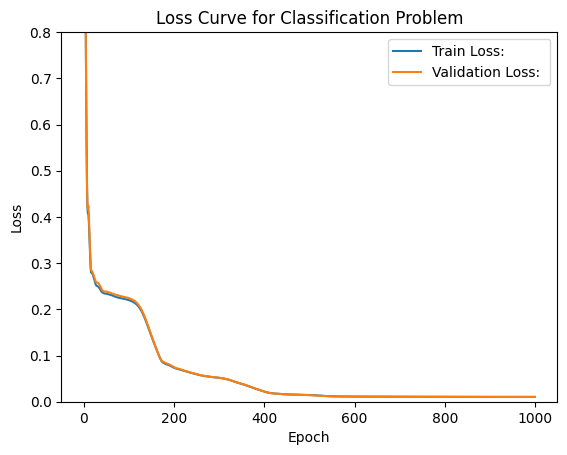

In [36]:
res = train_leapfrog_model(folds[0], hidden_dim=5, delta_max=0.5, time_step=0.1, max_epochs=1000, patience=300)
plot_results(res)

In [50]:
def optimize_hyper_params_lfrog(folds, time_list, delta_list, j_list, max_epochs=1000):
    results = {}
    for t in time_list:
        for d in delta_list:
            for j in j_list:
                results_per_config = {}
                for i in tqdm(range(len(folds))):
                    results_per_config[f'fold_{i}'] = train_leapfrog_model(folds[i], hidden_dim=5, max_epochs=max_epochs, time_step=t, delta_max=d, j_threshold=j, to_print=False, patience=1000)
                results[f'timestep_{t}_delta_{d}_J_{j}'] = results_per_config
    return results 

In [51]:
time_list = [0.1, 0.25, 0.5, 0.75, 1.0]
delta_list = [0.5, 1.0, 1.5, 2.0]
j_list = [1, 2, 3, 4]

lfrog_param_results = optimize_hyper_params_lfrog(folds, time_list, delta_list, j_list)
save_json(extract_losses_and_accuracy(lfrog_param_results), '../results/regression_2/lfrog_hyperparam_test.json')

100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


In [263]:
sort_configs(lfrog_param_results)

['timestep_1.0_delta_2.0_J_2',
 'timestep_0.75_delta_1.0_J_1',
 'timestep_1.0_delta_1.5_J_3',
 'timestep_1.0_delta_2.0_J_4',
 'timestep_1.0_delta_2.0_J_1',
 'timestep_0.5_delta_2.0_J_3',
 'timestep_0.5_delta_1.0_J_1',
 'timestep_0.5_delta_0.5_J_2',
 'timestep_0.5_delta_2.0_J_1',
 'timestep_0.25_delta_1.5_J_3',
 'timestep_0.25_delta_1.0_J_2',
 'timestep_0.25_delta_1.5_J_2',
 'timestep_0.25_delta_2.0_J_4',
 'timestep_0.25_delta_1.5_J_1',
 'timestep_0.75_delta_0.5_J_1',
 'timestep_0.5_delta_0.5_J_1',
 'timestep_0.1_delta_0.5_J_4',
 'timestep_0.1_delta_2.0_J_4',
 'timestep_0.75_delta_2.0_J_1',
 'timestep_0.75_delta_1.0_J_4',
 'timestep_0.75_delta_0.5_J_4',
 'timestep_1.0_delta_1.0_J_2',
 'timestep_0.75_delta_1.5_J_1',
 'timestep_0.75_delta_1.0_J_3',
 'timestep_1.0_delta_0.5_J_1',
 'timestep_1.0_delta_0.5_J_2',
 'timestep_0.5_delta_1.5_J_3',
 'timestep_1.0_delta_2.0_J_3',
 'timestep_0.5_delta_0.5_J_3',
 'timestep_0.75_delta_2.0_J_2',
 'timestep_1.0_delta_1.0_J_1',
 'timestep_0.5_delta_1.5_J

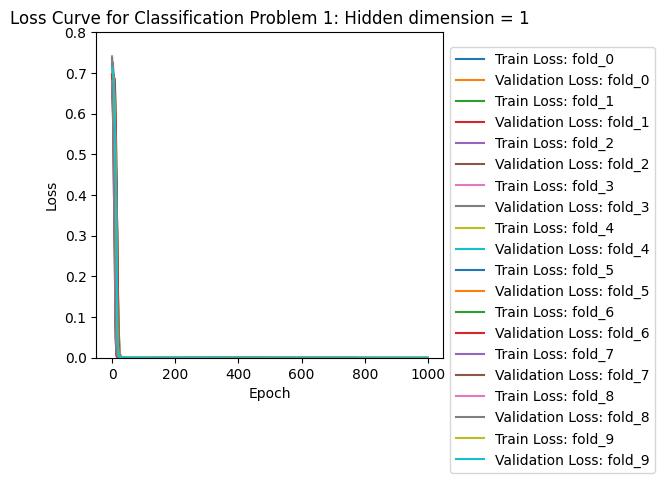

In [266]:
plot_per_dim(lfrog_param_results['timestep_1.0_delta_2.0_J_2'])

In [265]:
estimate_avg_time_to_convergence(lfrog_param_results['timestep_1.0_delta_2.0_J_2'])

{'val_wall_avg': 0.10776848793029785,
 'val_wall_std': 0.020444467076148484,
 'val_epoch_avg': 22.1,
 'val_epoch_std': 4.109744517606903,
 'train_wall_avg': 0.1035015344619751,
 'train_wall_std': 0.016644018701974395,
 'train_epoch_avg': 21.2,
 'train_epoch_std': 3.867815921162743}

## Evals

In [52]:
def stat_tests(sgd, scg, lfrog, metric, signifigance_level = 0.05, conv_threshold = 0.05):

    best_sgd_key = sort_configs(sgd, threshold=conv_threshold, test_key=metric)[0]
    best_scg_key = sort_configs(scg, threshold=conv_threshold, test_key=metric)[0]
    best_lfrog_key = sort_configs(lfrog, threshold=conv_threshold, test_key=metric)[0]

    sgd_data = find_time_to_convergence(dim_results_lr[best_sgd_key], threshold=conv_threshold)[metric]
    scg_data = find_time_to_convergence(scg_param_results[best_scg_key], threshold=conv_threshold)[metric]
    lfrog_data = find_time_to_convergence(lfrog_param_results[best_lfrog_key], threshold=conv_threshold)[metric]

    column_names = [f'fold {i}' for i in range(10)]
    df = pd.DataFrame([sgd_data, scg_data, lfrog_data], columns=column_names) 
    df = df.T
    df.columns = ['SGD', 'SCG', 'LFROG']

    map = {
        'val_wall': 'Validation Wall Time (Time to Convergence)',
        'val_epoch': 'Validation Epochs (Epochs to Convergence)', 
        'train_wall': 'Training Wall Time (Time to Convergence)',
        'train_epoch': 'Training Epochs (Epochs to Convergence)'
        }

    posthoc_results = sp.posthoc_nemenyi_friedman(df)
    plt.title(f'Signifigance Plot between best KNN and DT models based on {map[metric]}')
    sp.sign_plot(posthoc_results)
    plt.title('p-value')
    plt.show

    f = io.StringIO()
    with redirect_stdout(f):
        results = autorank(df, alpha=signifigance_level, verbose=False, force_mode='nonparametric', order='ascending')
    plot_stats(results)
    plt.title(f'Critical Distance plot based on {map[metric]}')
    plt.show()

    ranking_order = results.rankdf.index.tolist()
    for k in ranking_order:
        if k == 'SGD':
            out = estimate_avg_time_to_convergence(sgd[best_sgd_key], threshold=conv_threshold)
            para = best_sgd_key
        if k == 'SCG':
            out = estimate_avg_time_to_convergence(scg[best_scg_key], threshold=conv_threshold)
            para = best_scg_key
        if k == 'LFROG':
            out = estimate_avg_time_to_convergence(lfrog[best_lfrog_key], threshold=conv_threshold)
            para = best_lfrog_key
        print(f"{k}: {out[metric+'_avg']} ± {out[metric+'_std']} \t\t params: {para}")

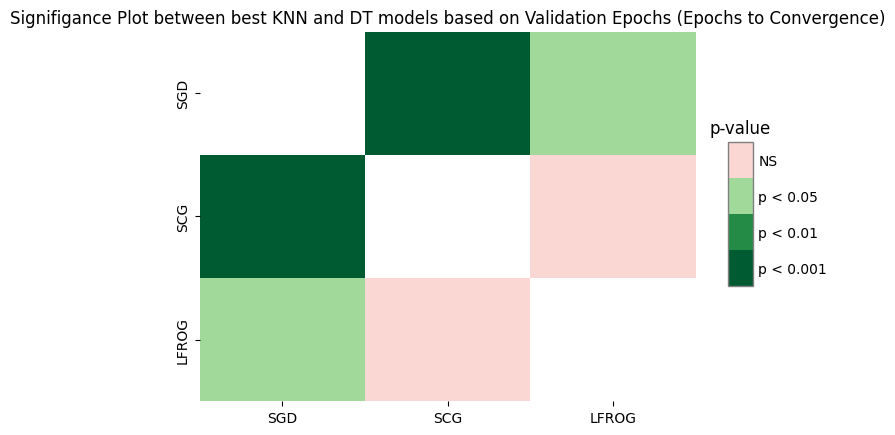

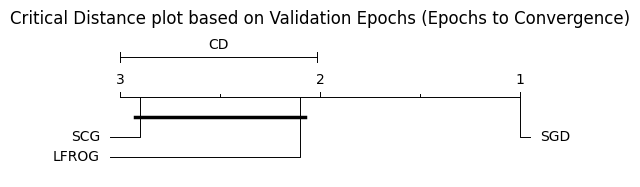

SGD: 1.0 ± 0.0 		 params: lr_0.01
LFROG: 41.1 ± 9.278469701410897 		 params: timestep_0.25_delta_0.5_J_1
SCG: 700029.6 ± 458212.3567123 		 params: sigma_3e-05_lambda_1e-05


In [53]:
stat_tests(dim_results_lr, scg_param_results, lfrog_param_results, metric='val_epoch', signifigance_level=0.07)

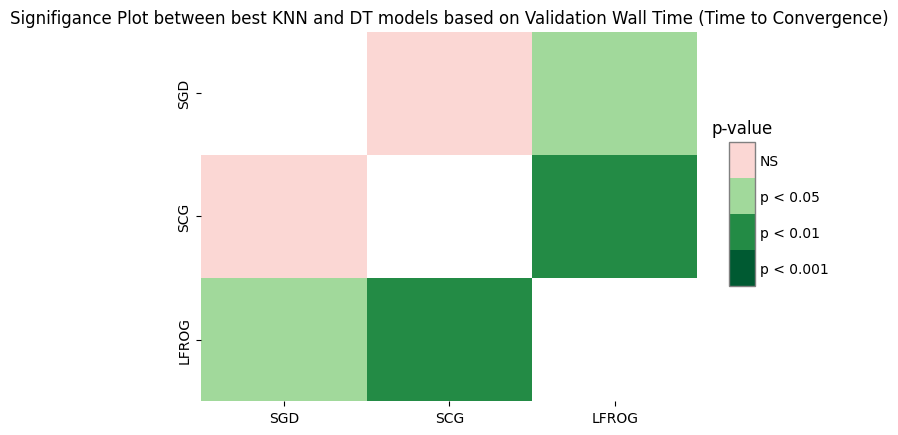

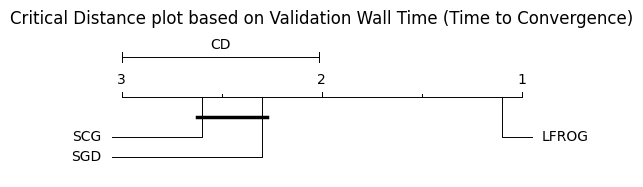

LFROG: 0.0897066354751587 ± 0.037507144745188674 		 params: timestep_0.25_delta_0.5_J_1
SGD: 4.196226572990417 ± 0.2621461277775563 		 params: lr_0.01
SCG: 700000.0841706514 ± 458257.44092280563 		 params: sigma_3e-05_lambda_1e-05


In [54]:
stat_tests(dim_results_lr, scg_param_results, lfrog_param_results, metric='val_wall', signifigance_level=0.07)

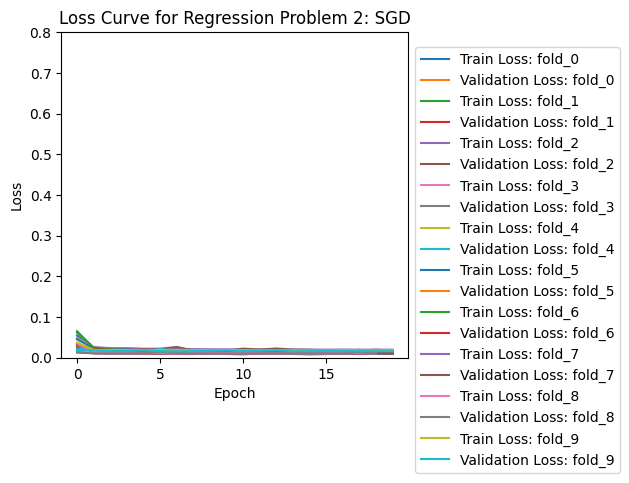

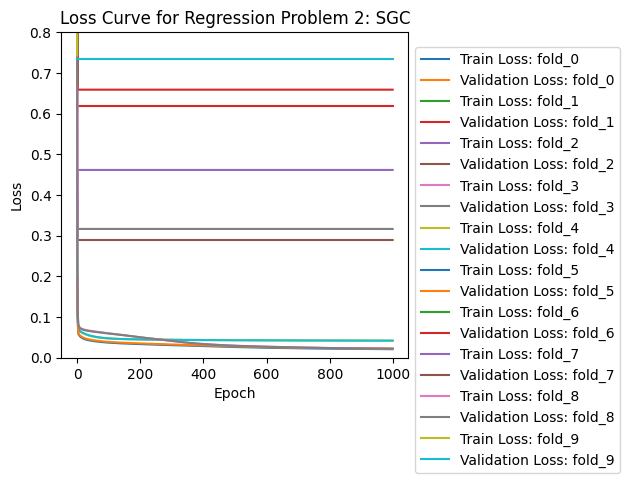

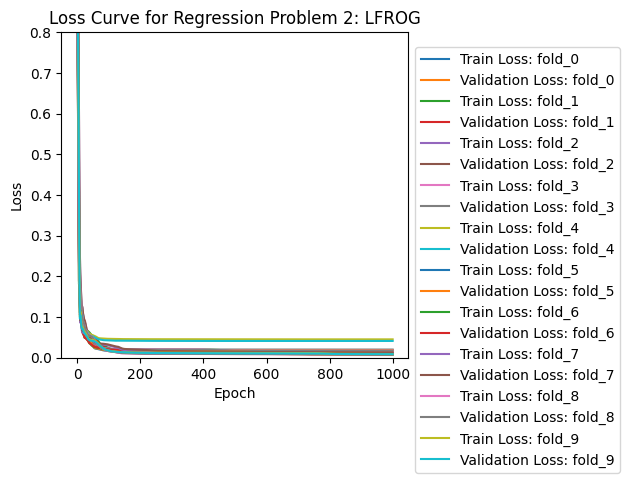

In [57]:
plot_per_dim(dim_results_lr['lr_0.01'], title="Loss Curve for Regression Problem 2: SGD")
plot_per_dim(scg_param_results['sigma_3e-05_lambda_1e-05'], title="Loss Curve for Regression Problem 2: SGC")
plot_per_dim(lfrog_param_results['timestep_0.25_delta_0.5_J_1'], title="Loss Curve for Regression Problem 2: LFROG")